In [1]:
import IPython
from IPython.display import display, HTML, SVG, Image
import graphviz
from graphviz import Source
from io import StringIO
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
plt.rcParams['figure.figsize'] = [10, 6] ## plot size
plt.rcParams['axes.linewidth'] = 2.0 #set the value globally
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_png { display: table-cell; text-align: center; vertical-align: middle; } </style>"))
display(HTML("<style>.MathJax {font-size: 100%;}</style>"))
def set_background(color):
    script = ( "var cell = this.closest('.code_cell');" "var editor = cell.querySelector('.input_area');" "editor.style.background='{}';" "this.parentNode.removeChild(this)" ).format(color)
    display(HTML('<img src onerror="{}">'.format(script)))

import pydotplus
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
from sklearn import tree
from sklearn.metrics import * 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
# Feature importance
import shap
import matplotlib.pyplot as plt
# load JS visualization code to notebook
shap.initjs()

In [2]:
#########################
#  Confusion Matrix
#########################
def displayConfusionMatrix(confusionMatrix, precisionNegative, precisionPositive, recallNegative, recallPositive, title):
    # Set font size for the plots. You can ignore this line.
    PLOT_FONT_SIZE = 14
    # Set plot size. Please ignore this line
    plt.rcParams['figure.figsize'] = [5, 5]
    # Transpose of confusion matrix to align the plot with the actual precision recall values. Please ignore this as well.
    confusionMatrix = np.transpose(confusionMatrix)
    # Plotting the confusion matrix
    plt.imshow(confusionMatrix, interpolation='nearest',cmap=plt.cm.Blues, vmin=0, vmax=100)
    
    # Setting plot properties. You should ignore everything from here on.
    xticks = np.array([-0.5, 0, 1,1.5])
    plt.gca().set_xticks(xticks)
    plt.gca().set_yticks(xticks)
    plt.gca().set_xticklabels(["", "Leave\nRecall=" + str(recallNegative) , "Stay\nRecall=" + str(recallPositive), ""], fontsize=PLOT_FONT_SIZE)
    plt.gca().set_yticklabels(["", "Leave\nPrecision=" + str(precisionNegative) , "Stay\nPrecision=" + str(precisionPositive), ""], fontsize=PLOT_FONT_SIZE)
    plt.ylabel("Predicted Class", fontsize=PLOT_FONT_SIZE)
    plt.xlabel("Actual Class", fontsize=PLOT_FONT_SIZE)
    plt.title(title, fontsize=PLOT_FONT_SIZE)
        
    # Add text in heatmap boxes
    for i in range(2):
        for j in range(2):
            text = plt.text(j, i, confusionMatrix[i][j], ha="center", va="center", color="white", size=15) ### size here is the size of text inside a single box in the heatmap
            
    plt.show()


#########################
# Calc/Print Metrics
#########################
def calculateMetricsAndPrint(predictions, predictionsProbabilities, actualLabels):
    
    # Get probabilities for the class with label 1. That is all we need to compute AUCs. We don't need probabilities for class 0.
    predictionsProbabilities = [item[1] for item in predictionsProbabilities]
    
    # Calculate metrics using scikit-learn functions. The round function is used to round the numbers up to 2 decimal points.
    accuracy = round(accuracy_score(actualLabels, predictions) * 100, 2)
    precisionNegative = round(precision_score(actualLabels, predictions, average = None)[0] * 100, 2)
    precisionPositive = round(precision_score(actualLabels, predictions, average = None)[1] * 100, 2)
    recallNegative = round(recall_score(actualLabels, predictions, average = None)[0] * 100, 2)
    recallPositive = round(recall_score(actualLabels, predictions, average = None)[1] * 100, 2)
    auc = round(roc_auc_score(actualLabels, predictionsProbabilities) * 100, 2)
    confusionMatrix = confusion_matrix(actualLabels, predictions)
    
    # Print metrics. .%2f prints a number upto 2 decimal points only.
    print("Accuracy: %.2f\nPrecisionNegative: %.2f\nPrecisionPositive: %.2f\nRecallNegative: %.2f\nRecallPositive: %.2f\nAUC Score: %.2f\n" % 
          (accuracy, precisionNegative, precisionPositive, recallNegative, recallPositive, auc))
    
    # Display confusion matrix
    displayConfusionMatrix(confusionMatrix, precisionNegative, precisionPositive, recallNegative, recallPositive, "Confusion Matrix")
    
    return auc

#########################
# Feature  Importance
#########################
def showFeatureImportance(classifier, columns):
    columns = columns[:-1]
    print(columns)
    
    # Plot size and font size
    plt.rcParams['figure.figsize'] = [16, 6]
    PLOT_FONT_SIZE = 14
    
    # Get feature importance values
    featureImportance = classifier.feature_importances_
    featureImportanceWithColumns = list(reversed(sorted([[featureImportance[i], columns[i]] for i in range(0, len(columns))])))
    sortedColumns = [item[1] for item in featureImportanceWithColumns]
    sortedFeatures = [item[0] for item in featureImportanceWithColumns]
    
    
    # Plotting
    xaxis = np.arange(len(featureImportance))
    plt.bar(xaxis, sortedFeatures, width = 0.5, color = 'white', hatch = '//', edgecolor = '#8a4191', linewidth = 2.0)
    plt.xticks(xaxis, sortedColumns, fontsize = PLOT_FONT_SIZE, rotation = 45)
    plt.yticks(fontsize = PLOT_FONT_SIZE)
    plt.xlabel("Feature Name",fontsize = PLOT_FONT_SIZE)
    plt.ylabel("Feature Importance",fontsize = PLOT_FONT_SIZE)
    plt.title("Feature Importances", fontsize = PLOT_FONT_SIZE)
    plt.show()
    
    # Table
    importanceDataFrame = pd.DataFrame(featureImportanceWithColumns)
    display(importanceDataFrame)
#################
# From DS1
#################
def summarize_dataframe(df):
    """Summarize a dataframe, and report missing values."""
    missing_values = pd.DataFrame({'Variable Name': df.columns,
                                   'Data Type': df.dtypes,
                                   'Missing Values': df.isnull().sum(),
                                   'Unique Values': [df[name].nunique() for name in df.columns]}
                                 ).set_index('Variable Name')
    with pd.option_context("display.max_rows", 1000):
        display(pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna(""))
########
# https://towardsdatascience.com/a-starter-pack-to-exploratory-data-analysis-with-python-pandas-seaborn-and-scikit-learn-a77889485baf
#######
def categorical_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', verbose=True):
    '''
    Helper function that gives a quick summary of a given column of categorical data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data, y would be the count
    y: str. vertical axis to plot the labels of categorical data, x would be the count
    hue: str. if you want to compare it another variable (usually the target variable)
    palette: array-like. Colour of the plot
    Returns
    =======
    Quick Stats of the data and also the count plot
    '''
    if x == None:
        column_interested = y
    else:
        column_interested = x
    series = dataframe[column_interested]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.countplot(x=x, y=y, hue=hue, data=dataframe, palette=palette)
    plt.show()

########
# https://towardsdatascience.com/a-starter-pack-to-exploratory-data-analysis-with-python-pandas-seaborn-and-scikit-learn-a77889485baf
#######
def quantitative_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', ax=None, verbose=True, swarm=False):
    '''
    Helper function that gives a quick summary of quantattive data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data (usually the target variable)
    y: str. vertical axis to plot the quantitative data
    hue: str. if you want to compare it another categorical variable (usually the target variable if x is another variable)
    palette: array-like. Colour of the plot
    swarm: if swarm is set to True, a swarm plot would be overlayed
    Returns
    =======
    Quick Stats of the data and also the box plot of the distribution
    '''
    series = dataframe[y]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.boxplot(x=x, y=y, hue=hue, data=dataframe, palette=palette, ax=ax)

    if swarm:
        sns.swarmplot(x=x, y=y, hue=hue, data=dataframe,
                      palette=palette, ax=ax)

    plt.show()


In [39]:
# Read data into a data frame
data = pd.DataFrame(pd.read_csv("Data/HiltonPredictionData_Train.csv", ","))
# Delete null values
data = data.dropna()
# Get column names. We will use these for visualization purposes
columns = list(data.columns)
# Display the data frame as a table
# display(data)

In [40]:
y = list(data['Department'].unique())
y.sort()
print(y)
print(len(y))

[1, 2, 3, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
40


In [42]:
# data[data['Department']==41]['Department'] = 1
data_new=data.copy()
data_new.loc[data['Department'] ==41, 'Department'] = 1
data_new[data['Department']==41]

,AnonymousID,HotelInncode,HotelBrand,HotelChainScale,Generation,Department,FullTimePartTime,Tenure,ManagementLevel,WorkLifeBalance,LearningDevelopment,Communication,Voice,RewardsBenefits,WorkEnvironment,IntentToStay
544,39702,100307,11,4,3,1,1,8,2,4.5,3.33,4.67,5.0,3.0,4.00,0
586,22723,100238,6,3,3,1,1,8,2,4.0,4.67,5.00,5.0,4.5,5.00,1
1712,25888,100254,2,3,2,1,1,8,1,5.0,4.67,5.00,5.0,4.5,4.50,1
1850,5718,100078,11,4,1,1,0,3,2,5.0,5.00,4.00,5.0,4.5,4.50,1
1950,12194,100078,11,4,1,1,0,5,2,3.5,3.33,3.00,4.0,4.0,4.00,0
2208,9388,100078,11,4,1,1,0,5,2,3.0,3.00,4.00,2.0,4.0,3.25,0
2635,2424,100078,11,4,2,1,1,7,1,4.0,4.33,5.00,5.0,4.5,4.75,1
2648,22712,100238,6,3,3,1,1,8,2,1.0,1.00,1.00,1.0,1.0,1.00,0
3009,31988,100254,2,3,2,1,1,8,1,5.0,5.00,5.00,5.0,5.0,5.00,1
3389,34524,100307,11,4,1,1,1,5,2,5.0,4.00,5.00,4.0,4.5,4.75,0


In [43]:
y = list(data_new['Department'].unique())
y.sort()
print(y)
print(len(y))


[1, 2, 3, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42]
39


In [37]:
# data.describe( )

In [36]:
# summarize_dataframe(data)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f60843637f0>,
      dtype=object)

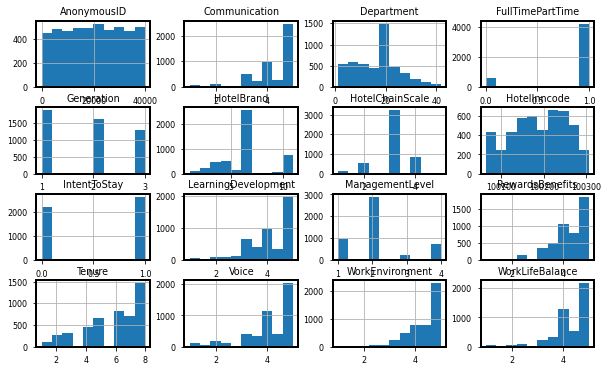

In [10]:
data.hist()

count    4800.000000
mean        0.546042
std         0.497928
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IntentToStay, dtype: float64
mode:  0    1
dtype: int64
1    2621
0    2179
Name: IntentToStay, dtype: int64


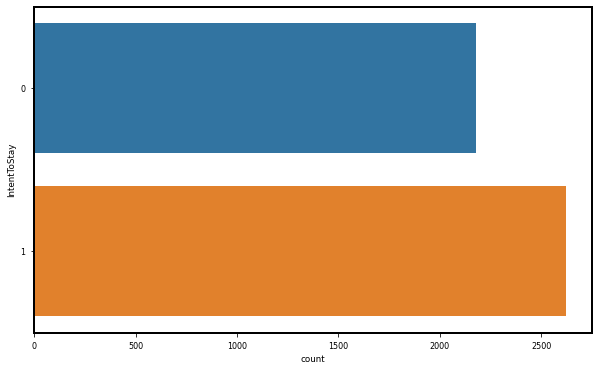

In [44]:
c_palette = ['tab:blue', 'tab:orange']
categorical_summarized(data, y = 'IntentToStay', palette=c_palette)

count    4800.000000
mean        0.546042
std         0.497928
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IntentToStay, dtype: float64
mode:  0    1
dtype: int64
1    2621
0    2179
Name: IntentToStay, dtype: int64


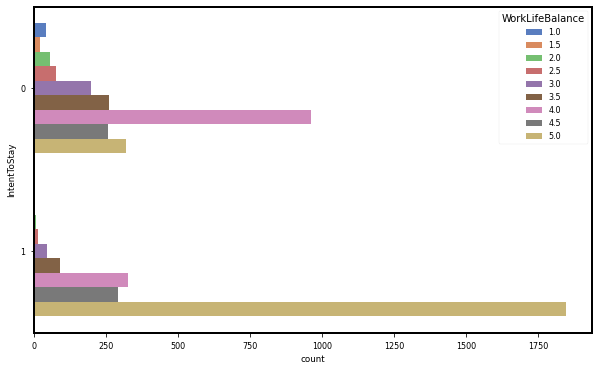

count    4800.000000
mean        0.546042
std         0.497928
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IntentToStay, dtype: float64
mode:  0    1
dtype: int64
1    2621
0    2179
Name: IntentToStay, dtype: int64


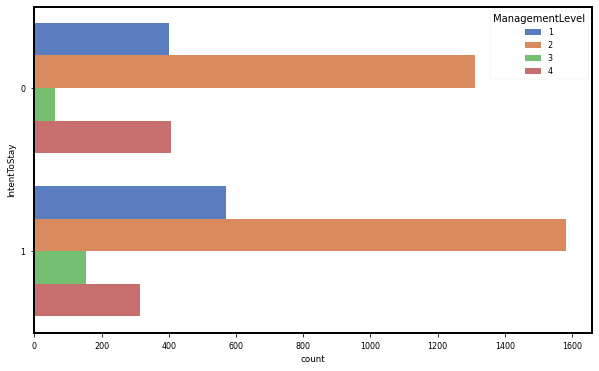

count    4800.000000
mean        0.546042
std         0.497928
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IntentToStay, dtype: float64
mode:  0    1
dtype: int64
1    2621
0    2179
Name: IntentToStay, dtype: int64


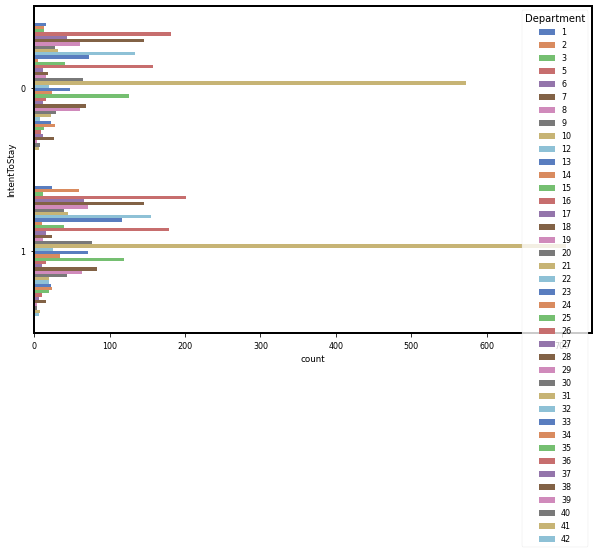

count    4800.000000
mean        0.546042
std         0.497928
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IntentToStay, dtype: float64
mode:  0    1
dtype: int64
1    2621
0    2179
Name: IntentToStay, dtype: int64


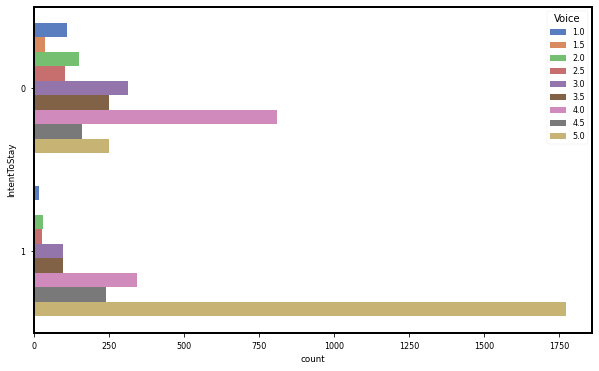

count    4800.000000
mean        0.546042
std         0.497928
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IntentToStay, dtype: float64
mode:  0    1
dtype: int64
1    2621
0    2179
Name: IntentToStay, dtype: int64


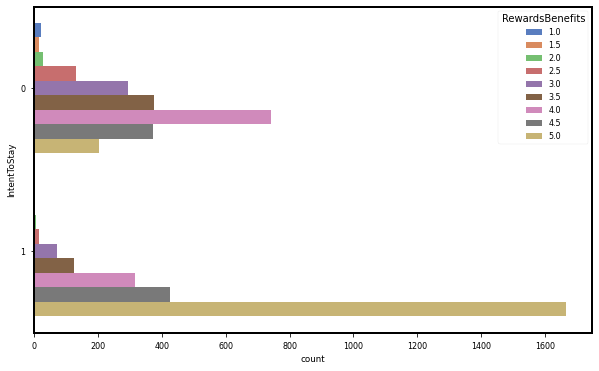

count    4800.000000
mean        0.546042
std         0.497928
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IntentToStay, dtype: float64
mode:  0    1
dtype: int64
1    2621
0    2179
Name: IntentToStay, dtype: int64


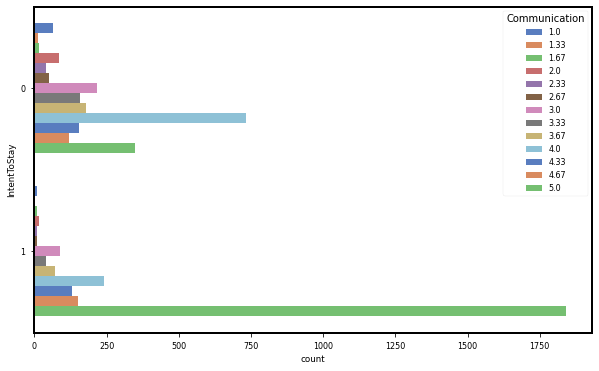

count    4800.000000
mean        0.546042
std         0.497928
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IntentToStay, dtype: float64
mode:  0    1
dtype: int64
1    2621
0    2179
Name: IntentToStay, dtype: int64


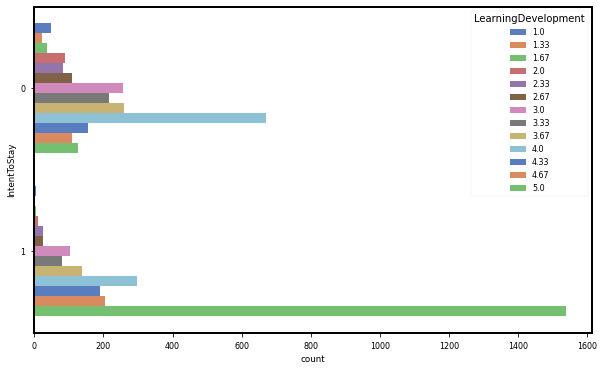

count    4800.000000
mean        0.546042
std         0.497928
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IntentToStay, dtype: float64
mode:  0    1
dtype: int64
1    2621
0    2179
Name: IntentToStay, dtype: int64


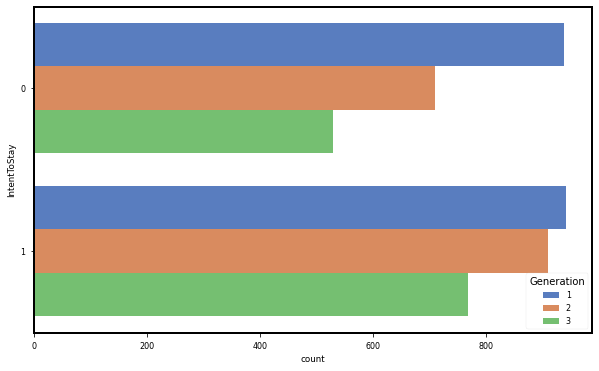

count    4800.000000
mean        0.546042
std         0.497928
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IntentToStay, dtype: float64
mode:  0    1
dtype: int64
1    2621
0    2179
Name: IntentToStay, dtype: int64


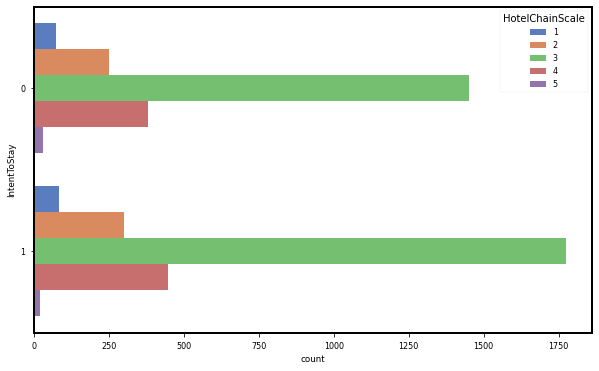

count    4800.000000
mean        0.546042
std         0.497928
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IntentToStay, dtype: float64
mode:  0    1
dtype: int64
1    2621
0    2179
Name: IntentToStay, dtype: int64


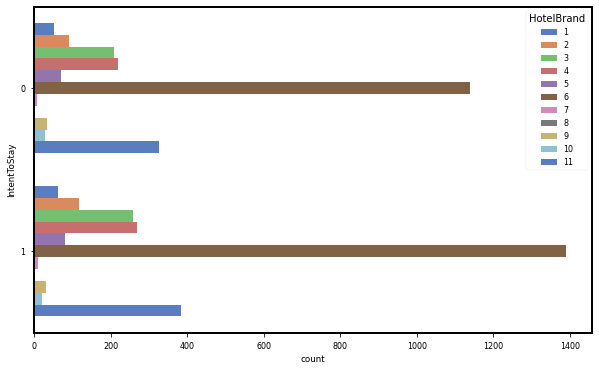

In [45]:
categorical_summarized(data, y = 'IntentToStay', hue='WorkLifeBalance', palette="muted")
categorical_summarized(data, y = 'IntentToStay', hue='ManagementLevel', palette="muted")
categorical_summarized(data, y = 'IntentToStay', hue='Department', palette="muted")
categorical_summarized(data, y = 'IntentToStay', hue='Voice', palette="muted")
categorical_summarized(data, y = 'IntentToStay', hue='RewardsBenefits', palette="muted")
categorical_summarized(data, y = 'IntentToStay', hue='Communication', palette="muted")
categorical_summarized(data, y = 'IntentToStay', hue='LearningDevelopment', palette="muted")
categorical_summarized(data, y = 'IntentToStay', hue='Generation', palette="muted")
categorical_summarized(data, y = 'IntentToStay', hue='HotelChainScale', palette="muted")
categorical_summarized(data, y = 'IntentToStay', hue='HotelBrand', palette="muted")


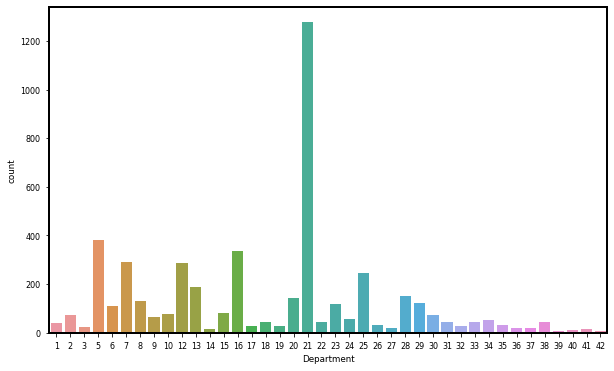

In [46]:
sns.countplot(x='Department', data=data)




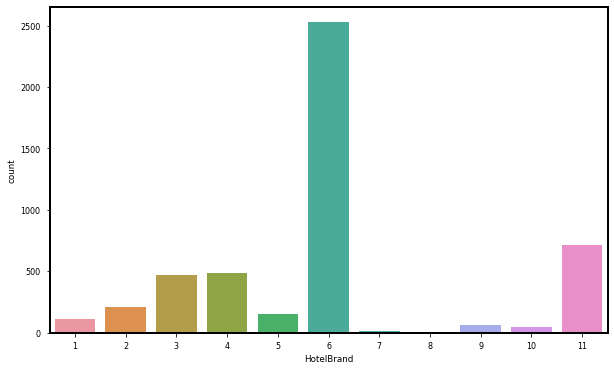

In [47]:
sns.countplot(x='HotelBrand', data=data)

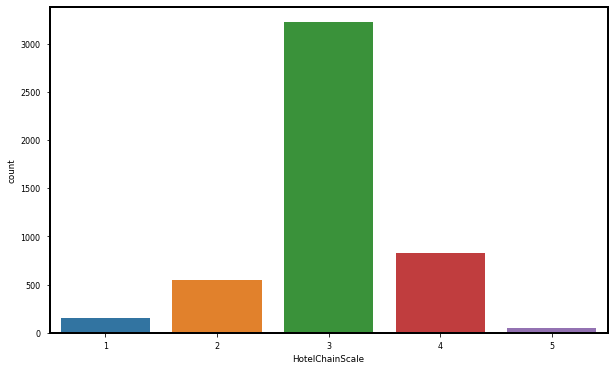

In [48]:
sns.countplot(x='HotelChainScale', data=data)


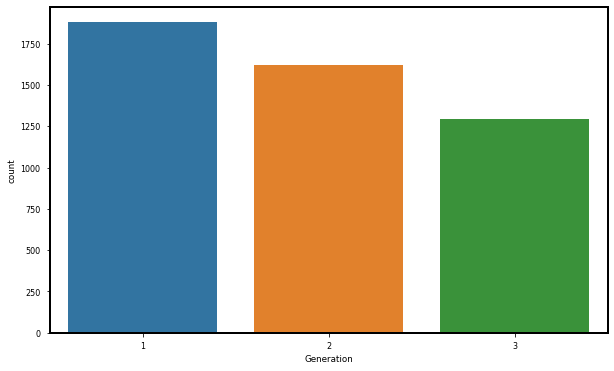

In [49]:
sns.countplot(x='Generation', data=data)

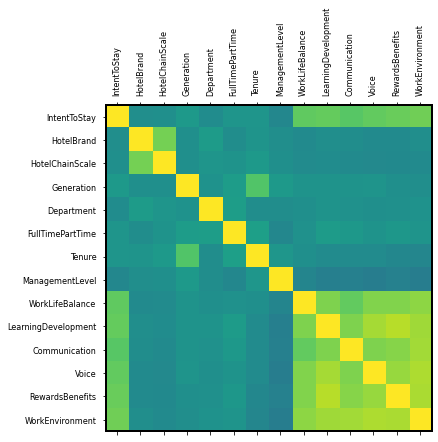

,IntentToStay,HotelBrand,HotelChainScale,Generation,Department,FullTimePartTime,Tenure,ManagementLevel,WorkLifeBalance,LearningDevelopment,Communication,Voice,RewardsBenefits,WorkEnvironment
IntentToStay,1.00,-0.01,-0.01,0.08,-0.03,0.04,0.04,-0.07,0.52,0.53,0.48,0.52,0.54,0.57
HotelBrand,-0.01,1.00,0.58,-0.01,0.10,-0.02,0.04,-0.01,-0.04,-0.02,-0.02,-0.04,-0.04,-0.01
HotelChainScale,-0.01,0.58,1.00,-0.01,0.05,0.03,0.08,-0.00,-0.04,-0.02,-0.05,-0.06,-0.05,-0.05
Generation,0.08,-0.01,-0.01,1.00,0.02,0.10,0.46,0.07,0.03,0.02,0.02,0.03,-0.00,-0.02
Department,-0.03,0.10,0.05,0.02,1.00,0.11,-0.02,-0.02,-0.00,0.03,0.01,-0.00,0.00,0.02
FullTimePartTime,0.04,-0.02,0.03,0.10,0.11,1.00,0.13,-0.08,0.01,0.10,0.07,0.03,0.06,0.04
Tenure,0.04,0.04,0.08,0.46,-0.02,0.13,1.00,0.05,-0.00,-0.03,-0.04,-0.03,-0.07,-0.08
ManagementLevel,-0.07,-0.01,-0.00,0.07,-0.02,-0.08,0.05,1.00,-0.09,-0.13,-0.13,-0.15,-0.12,-0.15
WorkLifeBalance,0.52,-0.04,-0.04,0.03,-0.00,0.01,-0.00,-0.09,1.00,0.61,0.52,0.62,0.62,0.66
LearningDevelopment,0.53,-0.02,-0.02,0.02,0.03,0.10,-0.03,-0.13,0.61,1.00,0.61,0.73,0.78,0.72


In [50]:
columns = list(data.columns)
corrcols = ['IntentToStay'] + columns[2:-1]
df = data[corrcols]
correlations = df.corr()
# print (correlations)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, interpolation='nearest', vmin = -1, vmax = 1)
# fig.colorbar(cax)
ticks = np.arange(0, 14, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(corrcols, rotation=90)
ax.set_yticklabels(corrcols)
plt.show()

correlations.style.background_gradient(cmap='coolwarm').set_precision(2)


In [51]:
# data.dtypes

In [53]:
data_new["Generation"] = data_new["Generation"].astype('category')
data_new["HotelBrand"] = data_new["HotelBrand"].astype('category')
data_new["Department"] = data_new["Department"].astype('category')
# data["HotelChainScale"] = obj_df["Generation"].astype('category')
data.dtypes



AnonymousID               int64
HotelInncode              int64
HotelBrand             category
HotelChainScale           int64
Generation             category
Department             category
FullTimePartTime          int64
Tenure                    int64
ManagementLevel           int64
WorkLifeBalance         float64
LearningDevelopment     float64
Communication           float64
Voice                   float64
RewardsBenefits         float64
WorkEnvironment         float64
IntentToStay              int64
dtype: object

In [54]:
from sklearn.preprocessing import OneHotEncoder

oe_style = OneHotEncoder()


In [55]:
depCols = []
for x in range(1,40):
    depCols.append('d'+str(x))
# depCols

In [57]:
gen = oe_style.fit_transform(data_new[["Generation"]])
pd.DataFrame(gen.toarray(), columns=['gen1','gen2','gen3']).head()

brand = oe_style.fit_transform(data_new[["HotelBrand"]])
pd.DataFrame(brand.toarray(), columns=['B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11']).head()

Department = oe_style.fit_transform(data_new[["Department"]])
pd.DataFrame(Department.toarray(), columns=depCols).head()

,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,...,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [58]:
data_new = data.join(pd.DataFrame(gen.toarray(), columns=['gen1','gen2','gen3']))
data_new = data_new.join(pd.DataFrame(brand.toarray(), columns=['B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11']))
data_new = data_new.join(pd.DataFrame(Department.toarray(), columns=depCols))



In [59]:
# Moves 'Intent to Stay" back to the end
col = list(data_new.columns.values)
df= data_new.pop("IntentToStay")
data_new['IntentToStay'] = df
data_new


,AnonymousID,HotelInncode,HotelBrand,HotelChainScale,Generation,Department,FullTimePartTime,Tenure,ManagementLevel,WorkLifeBalance,...,d31,d32,d33,d34,d35,d36,d37,d38,d39,IntentToStay
0,22684,100234,11,4,1,24,1,6,2,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,38792,100100,11,4,1,12,1,5,4,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,23552,100246,3,2,3,20,1,8,1,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,10801,100209,10,5,1,21,1,8,2,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,18343,100099,4,3,2,38,1,8,1,5.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,31739,100281,6,3,2,21,1,2,2,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4796,18126,100078,11,4,1,28,1,5,1,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4797,28158,100158,3,2,1,7,1,5,1,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4798,29268,100252,6,3,2,7,1,7,2,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


# Feature and Label Vectors

In [67]:
# columns = list(data_new.columns)
# df = data_new[columns]
# correlations = df.corr()
# print (correlations)

# fig = plt.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(correlations, interpolation='nearest', vmin = -1, vmax = 1)
# fig.colorbar(cax)
# # ticks = np.arange(0, 14, 1)
# ax.set_xticks(ticks)
# ax.set_yticks(ticks)
# ax.set_xticklabels(columns, rotation=90)
# ax.set_yticklabels(columns)
# plt.show()

# correlations.style.background_gradient(cmap='coolwarm').set_precision(2)


In [68]:
# c v

In [69]:
from sklearn.model_selection import GridSearchCV

# 5.3 Advanced Stuff: XgBoost
XgBoost (Gradient Boosted Trees) is the most widely used machine learning algorithm in the industry these days. It is a powerful algorithm that mixes decision trees, random forests, boosting, and gradients to come up effective classifiers for our data sets. Plenty of kaggle competitions have been won by using this algorithm.

In [70]:
from sklearn.ensemble import GradientBoostingClassifier


In [71]:
# x = list(data.columns)
# x
data_new

,AnonymousID,HotelInncode,HotelBrand,HotelChainScale,Generation,Department,FullTimePartTime,Tenure,ManagementLevel,WorkLifeBalance,...,d31,d32,d33,d34,d35,d36,d37,d38,d39,IntentToStay
0,22684,100234,11,4,1,24,1,6,2,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,38792,100100,11,4,1,12,1,5,4,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,23552,100246,3,2,3,20,1,8,1,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,10801,100209,10,5,1,21,1,8,2,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,18343,100099,4,3,2,38,1,8,1,5.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,31739,100281,6,3,2,21,1,2,2,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4796,18126,100078,11,4,1,28,1,5,1,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4797,28158,100158,3,2,1,7,1,5,1,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4798,29268,100252,6,3,2,7,1,7,2,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [72]:
# data = data_new
for i, col in enumerate(data_new) :
    print (str(i) + " " + str(col))

0 AnonymousID
1 HotelInncode
2 HotelBrand
3 HotelChainScale
4 Generation
5 Department
6 FullTimePartTime
7 Tenure
8 ManagementLevel
9 WorkLifeBalance
10 LearningDevelopment
11 Communication
12 Voice
13 RewardsBenefits
14 WorkEnvironment
15 gen1
16 gen2
17 gen3
18 B1
19 B2
20 B3
21 B4
22 B5
23 B6
24 B7
25 B8
26 B9
27 B10
28 B11
29 d1
30 d2
31 d3
32 d4
33 d5
34 d6
35 d7
36 d8
37 d9
38 d10
39 d11
40 d12
41 d13
42 d14
43 d15
44 d16
45 d17
46 d18
47 d19
48 d20
49 d21
50 d22
51 d23
52 d24
53 d25
54 d26
55 d27
56 d28
57 d29
58 d30
59 d31
60 d32
61 d33
62 d34
63 d35
64 d36
65 d37
66 d38
67 d39
68 IntentToStay


# 92.83
dataGB = data_new[['Tenure',  'WorkLifeBalance', 'LearningDevelopment', 'Communication', 'Voice', 'RewardsBenefits', 'WorkEnvironment','gen1', 'gen2', 'gen3','d2','d11', 'd36', 'IntentToStay']]
gbClassifier = GradientBoostingClassifier(learning_rate= 0.1, max_depth= 3, max_features=.8,min_impurity_decrease=.7, n_estimators= 350, subsample= .85, random_state = 1)

In [73]:
# For GBT and RF
dataGB = data[['Department',  'Tenure',  'WorkLifeBalance', 'LearningDevelopment', 'Communication', 'Voice','Generation', 'RewardsBenefits', 'WorkEnvironment', 'IntentToStay']]
#dataGB = data[['WorkLifeBalance', 'RewardsBenefits', 'Communication', 'LearningDevelopment', 'Voice', 'WorkEnvironment','Tenure','Generation','IntentToStay']]



# dataGB = data_new[['Department',  'Tenure',  'WorkLifeBalance', 'LearningDevelopment', 'Communication', 'Voice','Generation', 'RewardsBenefits', 'WorkEnvironment','gen1', 'gen2', 'gen3', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12', 'd13', 'd14', 'd15', 'd16', 'd17', 'd18', 'd19', 'd20', 'd21', 'd22', 'd23', 'd24', 'd25', 'd26', 'd27', 'd28', 'd29', 'd30', 'd31', 'd32', 'd33', 'd34', 'd35', 'd36', 'd37', 'd38', 'd39', 'd40', 'IntentToStay']]


dataGB = data_new[['Tenure',  'WorkLifeBalance', 'LearningDevelopment', 'Communication', 'Voice', 'RewardsBenefits', 'WorkEnvironment','gen1', 'gen2', 'gen3','d2','d11', 'd36', 'IntentToStay']]
gbClassifier = GradientBoostingClassifier(learning_rate= 0.1, max_depth= 3, max_features=.8,min_impurity_decrease=.7, n_estimators= 350, subsample= .85, random_state = 1)

# dataGB = data_new[['Tenure',  'WorkLifeBalance', 'LearningDevelopment', 'Communication', 'Voice', 'RewardsBenefits', 'WorkEnvironment','gen1', 'gen3','d11','d36', 'IntentToStay']]


gbCols = list(dataGB.columns)
dataGB = data_new[list(gbCols)]

print(gbCols)

# For logistic regression and SVMS
xDat = data[['Department',  'Tenure',  'WorkLifeBalance', 'LearningDevelopment', 'Communication', 'Voice','Generation', 'RewardsBenefits', 'WorkEnvironment',]]
lrCols = list(xDat.columns)
yDat = data[['IntentToStay']]

['Tenure', 'WorkLifeBalance', 'LearningDevelopment', 'Communication', 'Voice', 'RewardsBenefits', 'WorkEnvironment', 'gen1', 'gen2', 'gen3', 'd2', 'd11', 'd36', 'IntentToStay']


In [75]:
# dataGB

In [77]:
## ## 4.2 Feature and Label Vector
# Convert data to a list of lists1
dataList = dataGB.values.tolist()

# Get features
features = []

# Iterate over each row
for row in dataList:
    
    # Skip the first two columns because they are not needed and the last column because that's the label
    featureValues = row[:-1]

    # Replace NULL values with 0. Using an if-else statement within a list is called list comprehension
    featureValues = [float(value) if value != "#NULL!" else 0 for value in featureValues] 
    
    # Append the features to the feature list
    features.append(featureValues)
    
# Get labels from the data
labels = [row[-1] for row in dataList]

# Label distribution for Leave and Stay respectively
print("Label distribution of 0 and 1", labels.count(0), labels.count(1))

# Test data percentage (0.1 = 10%)
# Note - since the final test set is the blinded Kaggle data, this is essentially a validation set for parameter tuning
TEST_DATA_PERCENTAGE = 0.1

# Split into train and test
trainData, testData, trainLabels, testLabels = train_test_split(features, labels, test_size=TEST_DATA_PERCENTAGE)

Label distribution of 0 and 1 2179 2621


## 5.3.1 Grid Search on XgBoost
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [ ]:
set_background('#ffffff')
#####################################################################################################################################################
# Things you can change                                                                                                                             #
#####################################################################################################################################################
# GridSearchCV function takes in a parameter dictionary which is very important here. 
# The dictionary contains as keys the parameter names and values are the possible values of the parameter that you want to test
parameters = {'loss': ["deviance", "exponential"],
            'max_depth': [2,3, 4,5],
            'min_impurity_decrease': [0,.1,.05],
            'learning_rate': [.005,0.1,0.15],
            'n_estimators': [50,100,150,200],
            'max_features':['None',.8,.7,.6],
            'subsample': [.6,.7,.85,1.0]} 
            
parameters = {'max_depth': [3,4],
            'min_impurity_decrease': [0,.1,.05,.5,.7],
            'learning_rate': [.01,0.1,0.15],
            'n_estimators': [80,150,250,350],
            'max_features':['None',.8,],
            'subsample': [.85,1.0]} 

In [78]:
train=True

parameters = {'max_depth': [3],
            'min_impurity_decrease': [.6,.5,.7],
            'learning_rate': [.1,.13,.08],
            'n_estimators': [200,250,300],
            'max_features':[.8,.9,.6],
            'subsample': [.7,.85,1.0]} 

In [79]:

if (train) :
    gbClassifierWithGridSearch = GridSearchCV(GradientBoostingClassifier(),scoring='roc_auc', cv=5, param_grid=parameters, n_jobs=10, verbose=1)

    # Train the decision tree model using the function .fit
    gbClassifierWithGridSearch.fit(trainData, trainLabels)

    # Calculate training accuracy of the classifier
    # trainAccuracy = gbClassifierWithGridSearch.score(trainData, trainLabels)

    # Predict on test data
    # predictions = gbClassifierWithGridSearch.predict(testData) # This will give binary labels e.g 0/1
    # predictionProbabilities = gbClassifierWithGridSearch.predict_proba(testData) # This will give prediction probabilities for both labels e.g [0.3, 0.7] meaning 0.3 probability for 0 and 0.7 for 1.
    print("Best Parameters are: ", gbClassifierWithGridSearch.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    4.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   13.6s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   26.5s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   43.5s
[Parallel(n_jobs=10)]: Done 1215 out of 1215 | elapsed:  1.1min finished
Best Parameters are:  {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 0.6, 'min_impurity_decrease': 0.7, 'n_estimators': 200, 'subsample': 0.7}


In [80]:
# gbClassifier = GradientBoostingClassifier(learning_rate= 0.001, max_depth= 3, max_features=.7,min_impurity_decrease=.7, n_estimators= 350, subsample= .85, random_state = 1)

gbClassifier = GradientBoostingClassifier(learning_rate= 0.08, max_depth= 3, max_features=.6,min_impurity_decrease=.6, n_estimators= 250, subsample= .7, random_state = 1)
gbClassifier.fit(trainData, trainLabels)
trainAccuracy = gbClassifier.score(trainData, trainLabels)
predictions = gbClassifier.predict(testData) 
predictionProbabilities = gbClassifier.predict_proba(testData) 

Accuracy: 82.71
PrecisionNegative: 79.67
PrecisionPositive: 85.77
RecallNegative: 84.96
RecallPositive: 80.71
AUC Score: 90.19



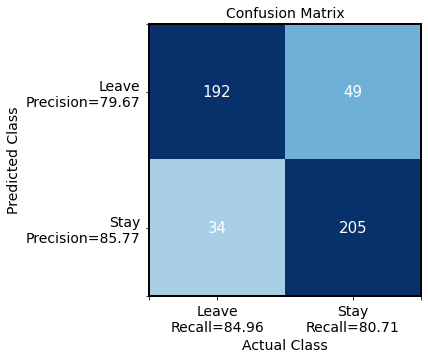

In [81]:
# Calculate metrics on test set and display them
gbtGridAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)

# Calculate FPR and TPR for use in ROC Curve Variance later on
falsePositiveRateGbWithGridSearch, truePositiveRateGbWithGridSearch, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])

# Unfortunately, Feature importance does not work with GridSearch. Instead, we will find the best parameters.


['Tenure', 'WorkLifeBalance', 'LearningDevelopment', 'Communication', 'Voice', 'RewardsBenefits', 'WorkEnvironment', 'gen1', 'gen2', 'gen3', 'd2', 'd11', 'd36']


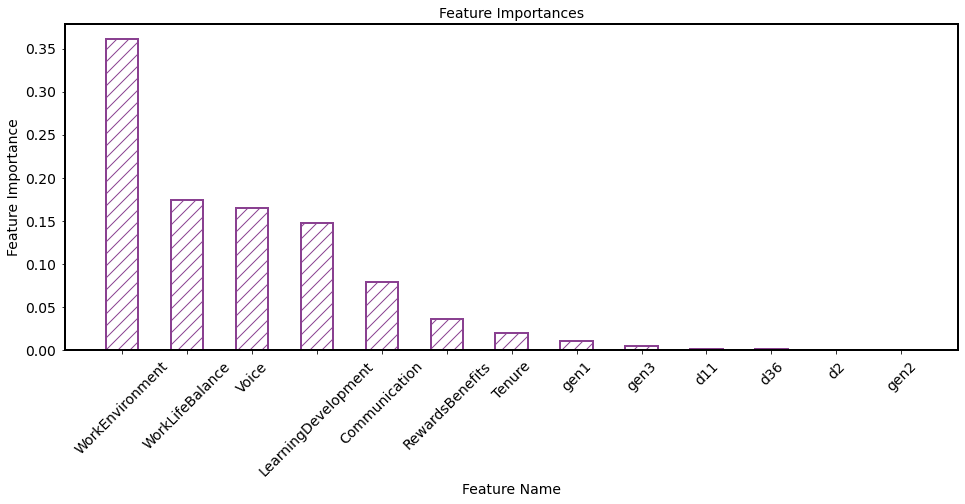

,0,1
0,0.360575,WorkEnvironment
1,0.174676,WorkLifeBalance
2,0.164585,Voice
3,0.147908,LearningDevelopment
4,0.078735,Communication
5,0.035856,RewardsBenefits
6,0.019315,Tenure
7,0.010845,gen1
8,0.005127,gen3
9,0.001067,d11


In [82]:
columns=list(dataGB.columns)
showFeatureImportance(gbClassifier, columns)

# Random Forrest

In [ ]:
if train :
    parameters = {'n_estimators': [400, 550],
                'max_features': ['auto',.7,.9],
                'min_samples_leaf': [25,50,75],
                'min_impurity_decrease': [0,.3]
                }


    rf_tuned = GridSearchCV(RandomForestClassifier(random_state=201,
                            ccp_alpha=10),param_grid=parameters, cv=4, n_jobs=6, verbose=1)
    rf_tuned.fit(trainData, trainLabels)
    rf_tuned.best_params_

In [ ]:
if train:
    rf_tuned.best_params_

In [ ]:

# rfClassifier = RandomForestClassifier(random_state=201, max_features='auto', min_samples_leaf=4, n_estimators=350, ccp_alpha=0) 92 AUC
rfClassifier = RandomForestClassifier(random_state=201, max_features='auto', min_samples_leaf=25, n_estimators=400,min_impurity_decrease=0, ccp_alpha=0)
rfClassifier.fit(trainData, trainLabels)
predictions = rfClassifier.predict(testData)
predictionProbabilities = rfClassifier.predict_proba(testData)

# Calculate metrics on test set and display them
rfAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)

# Calculate FPR and TPR for use in ROC Curve Variance later on
falsePositiveRateRF, truePositiveRateRF, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])
trainAccuracy = gbClassifier.score(trainData, trainLabels)
# Unfortunately, Feature importance does not work with GridSearch. Instead, we will find the best parameters.


In [ ]:
columns=list(dataGB.columns)
showFeatureImportance(rfClassifier, columns)

# Logistic Regression

In [ ]:
LogisticRegression().get_params().keys()

In [ ]:
# xDat = data[['WorkLifeBalance', 'RewardsBenefits', 'Communication', 'LearningDevelopment', 'Voice', 'WorkEnvironment','ManagementLevel','Generation']]

# xDat = data[['WorkLifeBalance', 'RewardsBenefits', 'Communication', 'LearningDevelopment', 'Voice', 'WorkEnvironment']]
# lrCols = list(xDat.columns)
# yDat = data[['IntentToStay']]

clf = LogisticRegression(solver='liblinear', random_state=0)

x= dict(C = np.logspace(-4, 4, 50), penalty = ['l1', 'l2'])
clfGS = GridSearchCV(clf, cv=5, param_grid=x, verbose=True, n_jobs=6)
clfGS.fit(xDat, yDat)
clfGS.best_estimator_.get_params()

predictions = clfGS.predict(testData)
predictionProbabilities = clfGS.predict_proba(xDat)

clfGS.best_estimator_.get_params()



In [ ]:
clf = LogisticRegression(solver='liblinear', random_state=0, C=16.768329368110066, penalty='l1').fit(xDat, yDat)

predictions = clf.predict(testData)
predictionProbabilities = clf.predict_proba(testData)



# Calculate metrics on test set and display them
lrAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)

# Calculate FPR and TPR for use in ROC Curve Variance later on
falsePositiveRateLR, truePositiveRateLR, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])
trainAccuracy = gbClassifier.score(trainData, trainLabels)


# SVC

In [ ]:
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV



In [ ]:
# clf = LinearSVC()
# model = CalibratedClassifierCV(clf) 
# model.fit(xDat, yDat)


# predictions = model.predict(testData)
# predictionProbabilities = model.predict_proba(testData)

# # # Calculate metrics on test set and display them
# svcAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)

# # # Calculate FPR and TPR for use in ROC Curve Variance later on
# falsePositiveRateSVC, truePositiveRateSVC, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])


In [ ]:
if train:
    param_grid = {'C': [0.5, .1, 1, 5, 10],  
                'gamma': [1, 0.1, 0.01, 0.001, 10], 
                'kernel': ['linear' ]}  
    
    grid = GridSearchCV(SVC(), param_grid, refit = True, verbose=5, n_jobs=8) 
    
    # fitting the model for grid search 
    grid.fit(xDat, yDat) 

    # print best parameter after tuning 
    print(grid.best_params_) 
    
    # print how our model looks after hyper-parameter tuning 
    print(grid.best_estimator_) 


In [ ]:
mySVC = SVC(C=1, gamma=.01, kernel='rbf', probability=True)
# mySVC = SVC(C=1, gamma=0.1, kernel='poly', degree=3, probability=True)
mySVC.fit(xDat, yDat) 


In [ ]:
myLinearSVC = SVC(C=0.1, gamma=1, kernel='linear', probability=True)

myLinearSVC.fit(xDat, yDat) 

predictions = myLinearSVC.predict(testData)
print(classification_report(testLabels, predictions)) 
predictionProbabilities = myLinearSVC.predict_proba(testData)

# # Calculate metrics on test set and display them
linearSvcAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)

# # Calculate FPR and TPR for use in ROC Curve Variance later on
falsePositiveRateSVC, truePositiveRateSVC, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])
# columns=list(dataGB.columns)

In [ ]:

predictions = mySVC.predict(testData)
print(classification_report(testLabels, predictions)) 
predictionProbabilities = mySVC.predict_proba(testData)

# # Calculate metrics on test set and display them
svcAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)

# # Calculate FPR and TPR for use in ROC Curve Variance later on
falsePositiveRateLinearSVC, truePositiveRateLinearSVC, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])

# Results

In [ ]:
print("AUC values for different classifiers...")
print("Gradient Boosted Trees: %.3f\nRandom Forrest: %.3f\nLogistic Reg: %.3f\nSVC: %.3f\nLinear SVC: %.3f" % (gbtGridAUC,rfAUC,lrAUC,svcAUC,linearSvcAUC))

In [ ]:
plt.rcParams['figure.figsize'] = [16, 8]
FONT_SIZE = 17

# plt.plot(falsePositiveRateDt, truePositiveRateDt, linewidth = 3, label = "DecisionTree(DT)")
# plt.plot(falsePositiveRateDtWithGridSearch, truePositiveRateDtWithGridSearch, linewidth = 3, label = "DTWithGridSearch")
# plt.plot(falsePositiveRateGb, truePositiveRateGb, linewidth = 3, label = "GradientBoostedTrees(GBT)")
plt.plot([0,1],[0,1], 'k--')
plt.plot(falsePositiveRateGbWithGridSearch, truePositiveRateGbWithGridSearch, linewidth = 5, label = "GBT " + str(gbtGridAUC), linestyle='--')
plt.plot(falsePositiveRateLR, truePositiveRateLR, linewidth = 3, label = "Logistic Regression " + str(lrAUC), linestyle='--')
plt.plot(falsePositiveRateRF, truePositiveRateRF, linewidth = 3, label = "Random Forrest " + str(rfAUC), alpha=.7, linestyle='--')
plt.plot(falsePositiveRateSVC, truePositiveRateSVC, linewidth = 3, label = "RGB SVC " + str(svcAUC), alpha=.7, linestyle='--')
plt.plot(falsePositiveRateLinearSVC, truePositiveRateLinearSVC, linewidth = 3, label = "Linear SVC " + str(svcAUC), alpha=.7, linestyle='--')
plt.legend(fontsize=FONT_SIZE)
plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)
plt.xlabel("False Positive Rate", fontsize=FONT_SIZE)
plt.ylabel("True Positive Rate", fontsize=FONT_SIZE)
plt.show()

In [87]:
# return the indicies from the original dataframe that we used as features in our model
def findIndiciesOfFeatures(features, original):
    indicies = []
    originalCols = list(original.columns)
    for feature in features :
        if feature in originalCols:
            # print(feature)
            # print (originalCols.index(feature))
            indicies.append(originalCols.index(feature))
    if(indicies[-1] == 15):
        indicies.pop()
    return indicies

# Test above function..
# print(np.array_equal(np.asarray(data.columns)[findIndiciesOfFeatures(dtCols,data)], dtCols[:-1]))
print(np.array_equal(np.asarray(data_new.columns)[findIndiciesOfFeatures(gbCols,data_new)], gbCols))
# print(np.array_equal(np.asarray(data.columns)[findIndiciesOfFeatures(lrCols,data_new)], lrCols))



True


In [ ]:
# findIndiciesOfFeatures(gbCols,data_new)
# data_new.columns[findIndiciesOfFeatures(gbCols,data_new)]

In [ ]:
# 0 'AnonymousID'
# 1 'HotelInncode'
# 2 'HotelBrand'
# 3 'HotelChainScale'
# 4 'Generation'
# 5 'Department'
# 6 'FullTimePartTime'
# 7 'Tenure'
# 8 'ManagementLevel'
# 9 'WorkLifeBalance'
# 10'LearningDevelopment'
# 11'Communication'
# 12'Voice'
# 13'RewardsBenefits'
# 14'WorkEnvironment'
# 15'IntentToStay'
# print(gbCols)
# print(dtCols)

In [89]:
# Read data into a data frame
testDataForSubmission = pd.DataFrame(pd.read_csv("Data/HiltonPredictionData_Test.csv", ","))
# Delete null values
testDataForSubmission = testDataForSubmission.dropna()
# Convert data to a list of lists
testDataListForSubmission = testDataForSubmission.values.tolist()

In [90]:
x = list(testDataForSubmission['Department'].unique())
# for i, dep in enumerate(x):
#     print (str(i) + " " + str(dep))



x.sort()
print(x)
print(len(x))


[1, 2, 3, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42]
39


In [91]:
# data = pd.DataFrame(pd.read_csv("Data/HiltonPredictionData_Train.csv", ","))
# data = data.dropna()
# train = list(data['Department'].unique())

# testDataForSubmission = pd.DataFrame(pd.read_csv("Data/HiltonPredictionData_Test.csv", ","))
# testDataForSubmission = testDataForSubmission.dropna()
# testDataListForSubmission = testDataForSubmission.values.tolist()
# test = list(testDataForSubmission['Department'].unique())


# train.sort()
# print(train)
# print(len(train))


# test.sort()
# print(test)
# print(len(test))


In [92]:
gen = oe_style.fit_transform(testDataForSubmission[["Generation"]])
pd.DataFrame(gen.toarray(), columns=['gen1','gen2','gen3']).head()

brand = oe_style.fit_transform(testDataForSubmission[["HotelBrand"]])
pd.DataFrame(brand.toarray(), columns=['B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11']).head()

Department = oe_style.fit_transform(testDataForSubmission[["Department"]])
pd.DataFrame(Department.toarray(), columns=depCols).head()


testDataForSubmission = testDataForSubmission.join(pd.DataFrame(gen.toarray(), columns=['gen1','gen2','gen3']))
testDataForSubmission = testDataForSubmission.join(pd.DataFrame(brand.toarray(), columns=['B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11']))
testDataForSubmission = testDataForSubmission.join(pd.DataFrame(Department.toarray(), columns=depCols))


# Moves 'Intent to Stay" back to the end
col = list(data_new.columns.values)
df= data_new.pop("IntentToStay")
data_new['IntentToStay'] = df
data_new


,AnonymousID,HotelInncode,HotelBrand,HotelChainScale,Generation,Department,FullTimePartTime,Tenure,ManagementLevel,WorkLifeBalance,...,d31,d32,d33,d34,d35,d36,d37,d38,d39,IntentToStay
0,22684,100234,11,4,1,24,1,6,2,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,38792,100100,11,4,1,12,1,5,4,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,23552,100246,3,2,3,20,1,8,1,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,10801,100209,10,5,1,21,1,8,2,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,18343,100099,4,3,2,38,1,8,1,5.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,31739,100281,6,3,2,21,1,2,2,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4796,18126,100078,11,4,1,28,1,5,1,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4797,28158,100158,3,2,1,7,1,5,1,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4798,29268,100252,6,3,2,7,1,7,2,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [98]:
# # Read data into a data frame
# testDataForSubmission = pd.DataFrame(pd.read_csv("Data/HiltonPredictionData_Test.csv", ","))
# # Delete null values
# testDataForSubmission = testDataForSubmission.dropna()
# # Convert data to a list of lists
# testDataListForSubmission = testDataForSubmission.values.tolist()
# Get features
testFeaturesForSubmissionDT = []
testFeaturesForSubmissionGB = []
testFeaturesForSubmissionLR = []
# Decision Tree
# indicies = findIndiciesOfFeatures(dtCols,data)
# for row in testDataListForSubmission:
#     # Skip the first two columns because they are not needed and the last column because that's the label
#     nprow = np.asarray(row)
#     # featureValues = nprow[[9,10,11,12,13,14]]
#     featureValues = nprow[[indicies]]
#     # Replace NULL values with 0. Using an if-else statement within a list is called list comprehension
#     featureValues = [float(value) if value != "#NULL!" else 0 for value in featureValues]  
#     # Append the features to the feature list
#     testFeaturesForSubmissionDT.append(featureValues)

indicies = findIndiciesOfFeaturesNew(gbCols,data_new)
for row in testDataListForSubmission:
    nprow = np.asarray(row)
    featureValues = nprow[[indicies]]
    # print(featureValues)
    # Replace NULL values with 0. Using an if-else statement within a list is called list comprehension
    featureValues = [float(value) if value != "#NULL!" else 0 for value in featureValues]  
    # Append the features to the feature list
    testFeaturesForSubmissionGB.append(featureValues)


# indicies = findIndiciesOfFeatures(lrCols,data)
# for row in testDataListForSubmission:
#     nprow = np.asarray(row)
#     featureValues = nprow[[indicies]]
#     # print(featureValues)
#     # Replace NULL values with 0. Using an if-else statement within a list is called list comprehension
#     featureValues = [float(value) if value != "#NULL!" else 0 for value in featureValues]  
#     # Append the features to the feature list
#     testFeaturesForSubmissionLR.append(featureValues)

IndexError: index 15 is out of bounds for axis 0 with size 15

In [97]:
# testFeaturesForSubmissionGB
gbCols

['Tenure',
 'WorkLifeBalance',
 'LearningDevelopment',
 'Communication',
 'Voice',
 'RewardsBenefits',
 'WorkEnvironment',
 'gen1',
 'gen2',
 'gen3',
 'd2',
 'd11',
 'd36',
 'IntentToStay']

In [94]:
# resultsFile = open("Results/rf.csv", "w")
# resultsFile.write("Id,Expected\n")
# for rfPredictionProb, i in zip(rfClassifier.predict_proba(testFeaturesForSubmissionGB), np.arange(len(testFeaturesForSubmissionGB))):
#     resultsFile.write(str(i + 1) + "," + str(rfPredictionProb[1]) + "\n")
# resultsFile.close()

resultsFile = open("Results/gb.csv", "w")
resultsFile.write("Id,Expected\n")
for gbPredictionProb, i in zip(gbClassifier.predict_proba(testFeaturesForSubmissionGB), np.arange(len(testFeaturesForSubmissionGB))):
    resultsFile.write(str(i + 1) + "," + str(gbPredictionProb[1]) + "\n")
resultsFile.close()

ValueError: Number of features of the model must match the input. Model n_features is 13 and input n_features is 7 

In [ ]:
# resultsFile = open("Results/gb_lr.csv", "w")
# resultsFile.write("Id,Expected\n")
# for clfPredictionProb,gbPredictionProb, i in zip(clf.predict_proba(testFeaturesForSubmissionLR),gbClassifier.predict_proba(testFeaturesForSubmissionGB), np.arange(len(testFeaturesForSubmissionGB))):
#     resultsFile.write(str(i + 1) + "," + str((float(gbPredictionProb[1])+float(clfPredictionProb[1]))/2) + "\n")
# resultsFile.close()


# resultsFile = open("Results/gb_lr_rf.csv", "w")
# resultsFile.write("Id,Expected\n")
# for rfPredictionProb,clfPredictionProb,gbPredictionProb, i in zip(rfClassifier.predict_proba(testFeaturesForSubmissionGB),clf.predict_proba(testFeaturesForSubmissionLR),gbClassifier.predict_proba(testFeaturesForSubmissionGB), np.arange(len(testFeaturesForSubmissionGB))):
#     resultsFile.write(str(i + 1) + "," + str((float(rfPredictionProb[1])+float(clfPredictionProb[1])+float(gbPredictionProb[1]))/3) + "\n")
# resultsFile.close()

resultsFile = open("Results/gb_rf.csv", "w")
resultsFile.write("Id,Expected\n")
for rfPredictionProb,gbPredictionProb, i in zip(rfClassifier.predict_proba(testFeaturesForSubmissionGB),gbClassifier.predict_proba(testFeaturesForSubmissionGB), np.arange(len(testFeaturesForSubmissionGB))):
    resultsFile.write(str(i + 1) + "," + str((float(rfPredictionProb[1])+float(gbPredictionProb[1]))/2) + "\n")
resultsFile.close()
    
print("All predictions have been placed in the results folder...")